In [ ]:
!git clone https://github.com/AndyLamperski/mechanical-samplers.git
%cd mechanical-samplers

In [ ]:


import mechsamp as ms
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import torch as pt
from tqdm import tqdm
import scipy.integrate as itg
import scipy.stats as st
import scipy.linalg as la
import numpy.polynomial.polynomial as poly

%matplotlib inline

In [ ]:
A = pt.tensor([[-1.,0],
               [0,-1],
               [1,1]])
b = pt.tensor([0,0,1])

loss = lambda x : pt.zeros_like(x)@x

eta = .001
foSamp = ms.FOLangevin(loss,eta,A,b)

x = pt.tensor([.5,.5],requires_grad=True)

X = []
NumSteps = 10000

for step in range(NumSteps):
    x = foSamp.step(x)
    X.append(x)
    
X = pt.stack(X)

X_np = X.detach().numpy()

plt.plot(X_np[:,0],X_np[:,1],'.')

100%|██████████| 10000/10000 [00:06<00:00, 1505.75it/s]


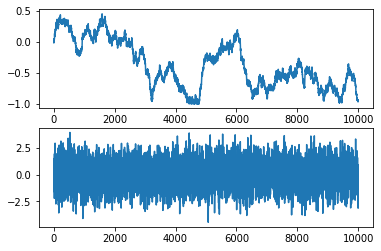

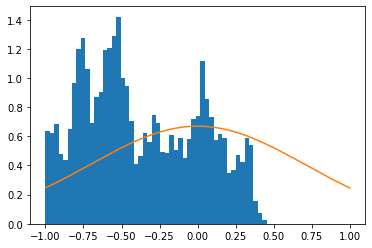

In [3]:
lossSq = lambda x,y : pt.sum((x-y)**2)
A = pt.tensor([[1.],
              [-1.]])
b = pt.tensor([1.,
             1.])

x = pt.tensor([0.],requires_grad=True)

a = .5
p = 1/(1-a**2)
NumSteps = 10000
y = pt.randn((1,)) * np.sqrt(p)

eta = 0.0001

foSamp = ms.FOLangevin(lossSq,eta,A,b)

X = [x]
Y = [y]

for step in tqdm(range(NumSteps)):
    x = foSamp.step(x,y)
    y = a*y + pt.randn((1,))
    
    X.append(x)
    Y.append(y)
    
    
X = pt.cat(X).detach().numpy()
Y = pt.cat(Y).detach().numpy()

fig,ax = plt.subplots(2,1)
ax[0].plot(X)
ax[1].plot(Y)

Z = itg.quad(lambda x : np.exp(-x**2),-1,1)[0]

x_pdf = np.linspace(-1,1,200)
pdf = np.exp(-x_pdf**2)/Z

plt.figure()
plt.hist(X,density=True,bins=50)
plt.plot(x_pdf,pdf)
    


In [ ]:
a = .5
NumSteps = int(2e6)
eta = 0.0001

p = 1/(1-a**2)

order = 4
mu = np.array([st.norm.moment(n,loc=0,scale=np.sqrt(p)) for n in range(order+1)])

x_poly = poly.Polynomial([0,1])
p_des = (x_poly+.4)**2 + 5 * (x_poly**2-.6)**2
plt.plot(x_pdf,p_des(x_pdf))

p_coef = p_des.coef
lam = p_coef / (mu@mu)
A = np.outer(lam,mu) + .1 * rnd.randn(order+1,order+1) @ ((mu@mu) * np.eye(order+1)-np.outer(mu,mu))


def polyLoss_np(x,y):
    m,n = A.shape
    
    X = np.stack([x**i for i in range(m)])
    Y = np.stack([y**i for i in range(n)])
    
    return X.T @ A @ Y

y = np.sqrt(p) * rnd.randn(1000)
lossRnd = polyLoss_np(x_pdf,y)
lossMean = np.mean(lossRnd,axis=1)
lossSem = st.sem(lossRnd,axis=1)
plt.fill_between(x_pdf,lossMean-lossSem,lossMean+lossSem,alpha=.3)
plt.plot(x_pdf,lossMean)

A_pt = pt.tensor(A,dtype=pt.float)
def polyLoss(x,y):
    m,n = A_pt.shape
    X = pt.cat([x**i for i in range(m)])
    Y = pt.cat([y**i for i in range(m)])
    return X@A_pt @ Y
    
    
Z = itg.quad(lambda x : np.exp(-p_des(x)),-1,1)[0]
    
x = pt.tensor([0.],requires_grad=True)

y = pt.randn((1,)) * np.sqrt(p)



A = pt.tensor([[1.],
              [-1.]])
b = pt.tensor([1.,
             1.])


foSamp = ms.FOLangevin(polyLoss,eta,A,b)

X = [x]
Y = [y]

for step in tqdm(range(NumSteps)):
    x = foSamp.step(x,y)
    y = a*y + pt.randn((1,))
    
    X.append(x)
    Y.append(y)
    
    
X = pt.cat(X).detach().numpy()
Y = pt.cat(Y).detach().numpy()


plt.figure()

plt.hist(X,density=True,bins=50)
plt.plot(x_pdf,np.exp(-p_des(x_pdf))/Z)


  7%|▋         | 142344/2000000 [01:30<17:51, 1733.40it/s]

In [ ]:
len(mu)
print(order+1)